# Interaction between SuPy and external models

## load necessary packages

In [1]:
import supy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
print('version info:')
print('supy:',sp.__version__)
print('supy_driver:',sp.__version_driver__)

version info:
supy: 2019.1.1
supy_driver: 2018b20


## run `SUEWS` with default settings

In [2]:
df_state_init, df_forcing = sp.load_SampleData()
df_output, df_state = sp.run_supy(df_forcing, df_state_init)
df_output_def = df_output.loc[1, 'SUEWS']

## a simple QF model: `QF_simple`

### construction

In [3]:
def QF_simple(T2):
    qf_cooling = (T2-20)*5 if T2 > 20 else 0
    qf_heating = (10-T2)*10 if T2 < 10 else 0
    qf_res = np.max([qf_heating, qf_cooling])*0.3
    return qf_res

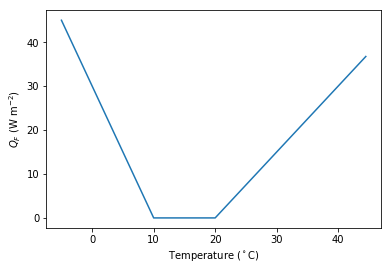

In [4]:
ser_temp = pd.Series(np.arange(-5, 45, 0.5)).rename('temp_C')
ser_qf = ser_temp.map(QF_simple).rename('qf')
df_temp_qf = pd.concat([ser_temp, ser_qf], axis=1).set_index('temp_C')
ax_qf_func = df_temp_qf.plot()
ax_qf_func.set_xlabel('Temperature ($^\circ$C)')
ax_qf_func.set_ylabel('$Q_F$ ($ \mathrm{W \ m^{-2}}$)')
ax_qf_func.legend().remove()


#### spinup for summer and winter run

In [5]:
df_output_june, df_state_jul = sp.run_supy(
    df_forcing.loc[:'2012 6'], df_state_init)
df_state_jul_init = df_state_jul.reset_index('datetime', drop=True).iloc[[-1]]


#### spinup run from July to October

In [6]:
df_output_oct, df_state_dec = sp.run_supy(
    df_forcing.loc['2012 7':'2012 11'], df_state_jul_init)
df_state_dec_init = df_state_dec.reset_index('datetime', drop=True).iloc[[-1]]

## communication between `supy` and  `QF_simple`

### construct a new coupled function

In [12]:
# load extra low-level functions from supy to construct interactive functions
from supy.supy_post import pack_df_output, pack_df_state
from supy.supy_run import suews_cal_tstep, pack_grid_dict

def run_supy_qf(df_forcing_test, df_state_init_test):
    #     df_state_init_test = df_state_jul_init.copy()
    df_state_init_test.loc[1, 'emissionsmethod'] = 0
    
    df_forcing_test = df_forcing_test\
        .assign(
            metforcingdata_grid=0,
            ts5mindata_ir=0,
        )\
        .rename(
            # remanae is a workaround to resolve naming inconsistency between
            # suews fortran code interface and input forcing file hearders
            columns={
                '%' + 'iy': 'iy',
                'id': 'id',
                'it': 'it',
                'imin': 'imin',
                'qn': 'qn1_obs',
                'qh': 'qh_obs',
                'qe': 'qe',
                'qs': 'qs_obs',
                'qf': 'qf_obs',
                'U': 'avu1',
                'RH': 'avrh',
                'Tair': 'temp_c',
                'pres': 'press_hpa',
                'rain': 'precip',
                'kdown': 'avkdn',
                'snow': 'snow_obs',
                'ldown': 'ldown_obs',
                'fcld': 'fcld_obs',
                'Wuh': 'wu_m3',
                'xsmd': 'xsmd',
                'lai': 'lai_obs',
                'kdiff': 'kdiff',
                'kdir': 'kdir',
                'wdir': 'wdir',
            }
        )

    t2_ext = df_forcing_test.iloc[0].temp_c
    qf_ext = QF_simple(t2_ext)

    # initialise dicts for holding results
    dict_state = {}
    dict_output = {}

    # starting tstep
    t_start = df_forcing_test.index[0]
    # convert df to dict with `itertuples` for better performance
    dict_forcing = {row.Index: row._asdict()
                    for row in df_forcing_test.itertuples()}
    # dict_state is used to save model states for later use
    dict_state = {
        (t_start, grid): pack_grid_dict(series_state_init)
        for grid, series_state_init
        in df_state_init_test.iterrows()
    }

    # just use a single grid run for the test coupling
    grid = 1

    for tstep in df_forcing_test.index:
        # load met forcing at `tstep`
        met_forcing_tstep = dict_forcing[tstep]
        # inject `qf_ext` to `met_forcing_tstep`
        met_forcing_tstep['qf_obs'] = qf_ext

        # update model state
        dict_state_start = dict_state[(tstep, grid)]

        dict_state_end, dict_output_tstep = suews_cal_tstep(
            dict_state_start, met_forcing_tstep)
        t2_ext = dict_output_tstep['dataoutlinesuews'][-3]
        qf_ext = QF_simple(t2_ext)

        dict_output.update({(tstep, grid): dict_output_tstep})
        dict_state.update({(tstep + 1, grid): dict_state_end})

    # pack results as easier DataFrames
    df_output_test = pack_df_output(dict_output).swaplevel(0, 1)
    df_state_test = pack_df_state(dict_state).swaplevel(0, 1)
    return df_output_test.loc[1, 'SUEWS'], df_state_test



### simulations for summer and winter months

In [16]:
df_forcing.loc['2012 7'].columns

Index(['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH',
       'Tair', 'pres', 'rain', 'kdown', 'snow', 'ldown', 'fcld', 'Wuh', 'xsmd',
       'lai', 'kdiff', 'kdir', 'wdir', 'isec'],
      dtype='object')

In [17]:
df_output_test_summer, df_state_summer_test = run_supy_qf(
    df_forcing.loc['2012 7'], df_state_jul_init.copy())
df_output_test_winter, df_state_winter_test = run_supy_qf(
    df_forcing.loc['2012 12'], df_state_dec_init.copy())

### examine the results

#### sumer

Text(0, 0.5, '$Q_F$ ($ \\mathrm{W \\ m^{-2}}$)')

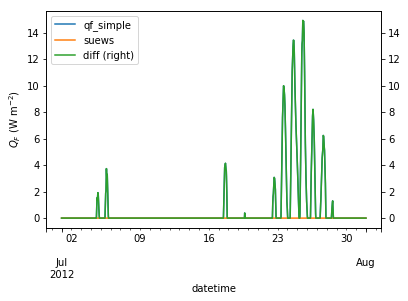

In [18]:
var = 'QF'
var_label = '$Q_F$ ($ \mathrm{W \ m^{-2}}$)'
period = '2012 7'
df_test = df_output_test_summer
y1 = df_test.loc[period, var].rename('qf_simple')
y2 = df_output_def.loc[period, var].rename('suews')
y3 = (y1-y2).rename('diff')
df_plot = pd.concat([y1, y2, y3], axis=1)
ax = df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label)
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')



Text(0, 0.5, '$T_2$ ($^{\\circ}$C)')

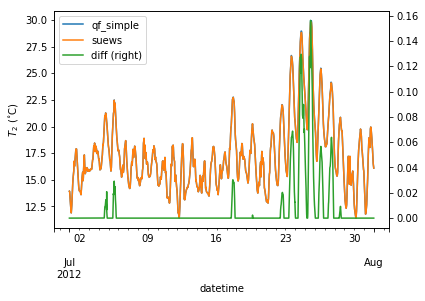

In [19]:
var = 'T2'
var_label = '$T_2$ ($^{\circ}$C)'
period = '2012 7'
df_test = df_output_test_summer
y1 = df_test.loc[period, var].rename('qf_simple')
y2 = df_output_def.loc[period, var].rename('suews')
y3 = (y1-y2).rename('diff')
df_plot = pd.concat([y1, y2, y3], axis=1)
ax = df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label)


In [20]:
df_plot = pd.DataFrame(df_plot)

Text(0.5, 0, 'Temperature ($^{\\circ}$C)')

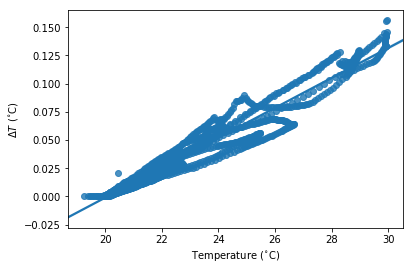

In [21]:
ax_t2diff = sns.regplot(
    data=df_plot.loc[df_plot['diff'] > 0], x='qf_simple', y='diff')
ax_t2diff.set_ylabel('$\Delta T$ ($^{\circ}$C)')
ax_t2diff.set_xlabel('Temperature ($^{\circ}$C)')

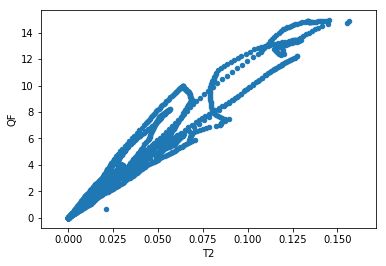

In [22]:
df_diff_summer = (df_output_test_summer -
                  df_output_def).dropna(how='all', axis=0)
df_diff_summer.loc[:, ['QF', 'T2']].plot.scatter(x='T2', y='QF')


#### winter

Text(0, 0.5, '$Q_F$ ($ \\mathrm{W \\ m^{-2}}$)')

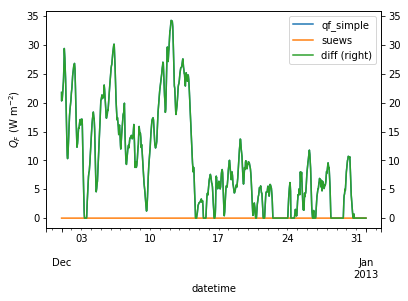

In [23]:
var = 'QF'
var_label = '$Q_F$ ($ \mathrm{W \ m^{-2}}$)'
period = '2012 12'
df_test = df_output_test_winter
y1 = df_test.loc[period, var].rename('qf_simple')
y2 = df_output_def.loc[period, var].rename('suews')
y3 = (y1-y2).rename('diff')
df_plot = pd.concat([y1, y2, y3], axis=1)
ax = df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label)
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')



Text(0, 0.5, '$T_2$ ($^{\\circ}$C)')

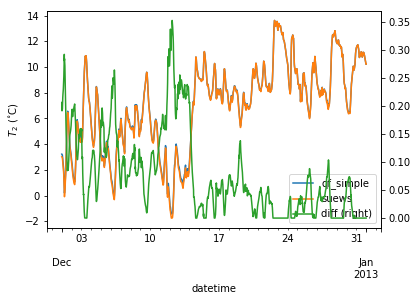

In [24]:
var = 'T2'
var_label = '$T_2$ ($^{\circ}$C)'
period = '2012 12'
df_test = df_output_test_winter
y1 = df_test.loc[period, var].rename('qf_simple')
y2 = df_output_def.loc[period, var].rename('suews')
y3 = (y1-y2).rename('diff')
df_plot = pd.concat([y1, y2, y3], axis=1)
ax = df_plot.plot(secondary_y='diff')
ax.set_ylabel(var_label)
# sns.lmplot(data=df_plot,x='qf_simple',y='diff')


Text(0.5, 0, 'Temperature ($^{\\circ}$C)')

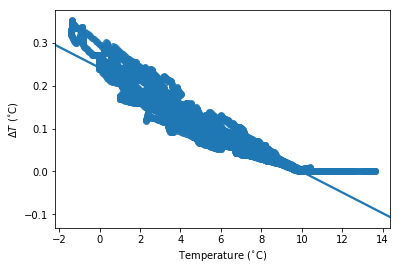

In [25]:
ax_t2diff = sns.regplot(
    data=df_plot.loc[df_plot['diff'] > 0],
    x='qf_simple', y='diff')
ax_t2diff.set_ylabel('$\Delta T$ ($^{\circ}$C)')
ax_t2diff.set_xlabel('Temperature ($^{\circ}$C)')


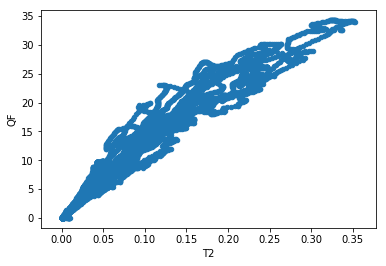

In [26]:
df_diff_winter = (df_output_test_winter
                  - df_output_def).dropna(how='all',
                                          axis=0).loc[:, ['QF', 'T2']]
df_diff_winter.plot.scatter(x='T2', y='QF')


#### comparison in $\Delta Q_F$-$\Delta T2$ feedback between summer and winter

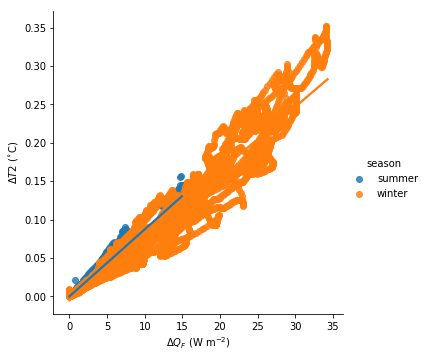

In [27]:
df_diff_season = pd.concat([
    df_diff_summer.assign(season='summer'),
    df_diff_winter.assign(season='winter'),
]).loc[:, ['season', 'QF', 'T2']]
g = sns.lmplot(
    data=df_diff_season,
    x='QF', y='T2', hue='season',
    truncate=True)
g.set_axis_labels(
    '$\Delta Q_F$ ($ \mathrm{W \ m^{-2}}$)', '$\Delta T2$ ($^{\circ}$C)')

